<a href="https://colab.research.google.com/github/leehanchung/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_8_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [0]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [0]:
import pandas as pd
import numpy as np

# Modeling
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from xgboost import plot_importance
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

import datetime as dt
from datetime import date

## 1.1 Merging Store with Train and Test

In [0]:
train = train.merge(store, on='Store')
test = test.merge(store, on='Store')

## 1.4 Target Before And After Log Transform

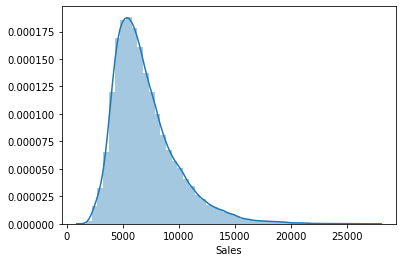

In [0]:
y_train = train.Sales
sns.distplot(y_train);

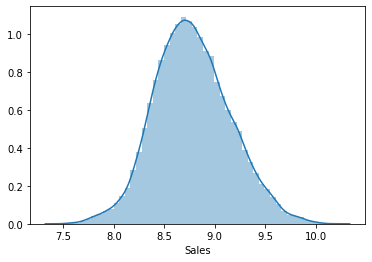

In [0]:
sns.distplot(np.log1p(y_train));

In [0]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,78400.000000,78400.000000,78400.000000,78400.000000,78400.000000,78400.000000,78400.000000,65072.00000,65072.000000,78400.000000,15680.000000,15680.000000
mean,544.690000,3.506378,6988.430778,826.109847,0.450255,0.195268,4731.200000,7.13253,2010.963855,0.200000,24.450000,2011.600000
std,325.893217,1.710560,2824.069622,316.205067,0.497522,0.396409,8911.590516,3.22930,2.451700,0.400003,13.596297,0.969567
min,4.000000,1.000000,1712.000000,206.000000,0.000000,0.000000,30.000000,1.00000,2006.000000,0.000000,1.000000,2010.000000
25%,259.250000,2.000000,5005.000000,599.000000,0.000000,0.000000,700.000000,4.00000,2009.000000,0.000000,14.000000,2011.000000
50%,550.000000,3.000000,6370.000000,757.000000,0.000000,0.000000,1945.000000,9.00000,2011.000000,0.000000,22.000000,2012.000000
75%,826.500000,5.000000,8303.000000,993.000000,1.000000,0.000000,3797.500000,9.00000,2013.000000,0.000000,35.000000,2012.000000
max,1113.000000,6.000000,27265.000000,3360.000000,1.000000,1.000000,48330.000000,12.00000,2015.000000,1.000000,48.000000,2013.000000


In [0]:
print(train.shape)
train.isna().sum()

(78400, 16)


Store                            0
DayOfWeek                        0
Date                             0
Sales                            0
Customers                        0
Promo                            0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance              0
CompetitionOpenSinceMonth    13328
CompetitionOpenSinceYear     13328
Promo2                           0
Promo2SinceWeek              62720
Promo2SinceYear              62720
PromoInterval                62720
dtype: int64

## 1.1 Cleanup CompetitionOpenSinceX

We will create a new feature called MonthsCompetition that markes how many months since a competition open near a store. Since CompetitionOpenSinceMonth and CompetitionOpenSinceYear are missing for some stores, we will impute them with first transaction date of the store.

In [0]:
train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

In [0]:
train.isna().sum()

Store                            0
DayOfWeek                        0
Date                             0
Sales                            0
Customers                        0
Promo                            0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance              0
CompetitionOpenSinceMonth    13328
CompetitionOpenSinceYear     13328
Promo2                           0
Promo2SinceWeek              62720
Promo2SinceYear              62720
PromoInterval                62720
Year                             0
Month                            0
Day                              0
dtype: int64

In [0]:
train.groupby(['Store'])['Date'].min().unique(), test.groupby(['Store'])['Date'].min().unique()

(array(['2013-01-02T00:00:00.000000000'], dtype='datetime64[ns]'),
 array(['2013-01-02'], dtype=object))

In [0]:
train.CompetitionOpenSinceMonth.fillna(1, inplace=True)

In [0]:
train.CompetitionOpenSinceYear.fillna(2013, inplace=True)

In [0]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,4,5,2015-07-31,13995,1498,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31
1,4,4,2015-07-30,10387,1276,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,30
2,4,3,2015-07-29,10514,1258,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,29
3,4,2,2015-07-28,10275,1191,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,28
4,4,1,2015-07-27,11812,1379,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,27


## 1.2 Cleanup PromoX

In [0]:
train.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     7056
Mar,Jun,Sept,Dec    5488
Feb,May,Aug,Nov     3136
Name: PromoInterval, dtype: int64

In [0]:
print(train.groupby(['Store'])['Promo2SinceYear'].describe().dropna().index)
print(train.groupby(['Store'])['PromoInterval'].describe().dropna().index)
print(train.groupby(['Store'])['Promo2SinceWeek'].describe().dropna().index)

Int64Index([  11,   12,   68,  101,  248,  344,  377,  398,  459,  487,  566,
             577,  680,  802,  822,  862,  914, 1010, 1071, 1106],
           dtype='int64', name='Store')
Int64Index([  11,   12,   68,  101,  248,  344,  377,  398,  459,  487,  566,
             577,  680,  802,  822,  862,  914, 1010, 1071, 1106],
           dtype='int64', name='Store')
Int64Index([  11,   12,   68,  101,  248,  344,  377,  398,  459,  487,  566,
             577,  680,  802,  822,  862,  914, 1010, 1071, 1106],
           dtype='int64', name='Store')


It seems that some stores are just not running any promo2s.  So we will leave the NaN and let encoder handle them.

In [0]:
def cleaning(df):
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    
    df.CompetitionOpenSinceMonth.fillna(1, inplace=True)
    df.CompetitionOpenSinceYear.fillna(2013, inplace=True)
    
    df.fillna(0, inplace=True)
    
    return df

## 1.2-3 Arrange Features Matrices and Target Vector and Log Transform Target Vector

First we will reload the data to get a clean slate

In [0]:
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)
train = train.merge(store, on='Store')
test = test.merge(store, on='Store')

In [0]:
train = cleaning(train)
test = cleaning(test)

In [0]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,4,5,2015-07-31,13995,1498,1,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31
1,4,4,2015-07-30,10387,1276,1,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,30
2,4,3,2015-07-29,10514,1258,1,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,29
3,4,2,2015-07-28,10275,1191,1,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,28
4,4,1,2015-07-27,11812,1379,1,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,27


In [0]:
features = ['Store', 'DayOfWeek', 'Customers', 'Promo', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2']
target = ['Sales']

In [0]:
# For simplification, log transform both y_train and y_test so we can use RMSE directly
# during our randomized search to present RMSLE.
X_train = train[features]
y_train = np.log1p(train[target])
X_test = test[features]
y_test = np.log1p(test[target])

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all rows for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all rows for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all rows for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

## 2.1 RandomizedSearchCV, 10 Candidates, 20 Fits

In [0]:
xgbr = XGBRegressor(random_state=45, nrounds = 'min.error.idx', eval_metric = 'rmse',
                    verbosity=1, nthread=-1, early_stopping_rounds=8,
                    max_depth = 3, n_estimators = 100, learning_rate=0.1)

encoder = ce.OrdinalEncoder()
xgbr_pipe = Pipeline(steps=[('encoder', encoder),
                            ('xgbr', xgbr)])

param_grid = {
    "xgbr__max_depth": [3, 4, 5],
    "xgbr__n_estimators": [100, 200],
    "xgbr__learning_rate": [0.1, 0.3],
}

xgb_gs = RandomizedSearchCV(xgbr_pipe, param_distributions=param_grid, n_jobs=-1, cv=2, verbose=True)

In [0]:
xgb_gs.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   28.3s finished


[17:50:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('encoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('xgbr',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=

## 2.2 Validation Scores in Randomized Search

In [0]:
results = pd.DataFrame(xgb_gs.cv_results_)
results[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'xgbr__n_estimators': 200, 'xgbr__max_depth':...",0.718445,0.024465
1,"{'xgbr__n_estimators': 200, 'xgbr__max_depth':...",0.707831,0.007093
2,"{'xgbr__n_estimators': 200, 'xgbr__max_depth':...",0.638932,0.084757
3,"{'xgbr__n_estimators': 200, 'xgbr__max_depth':...",0.705260,0.006101
4,"{'xgbr__n_estimators': 100, 'xgbr__max_depth':...",0.748567,0.000589
5,"{'xgbr__n_estimators': 100, 'xgbr__max_depth':...",0.696441,0.011820
6,"{'xgbr__n_estimators': 200, 'xgbr__max_depth':...",0.688102,0.008115
7,"{'xgbr__n_estimators': 100, 'xgbr__max_depth':...",0.693678,0.051707
8,"{'xgbr__n_estimators': 200, 'xgbr__max_depth':...",0.659365,0.047030
9,"{'xgbr__n_estimators': 100, 'xgbr__max_depth':...",0.659062,0.052089


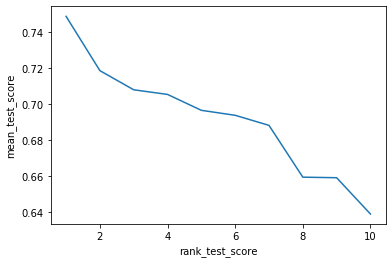

In [0]:
sns.lineplot(x="rank_test_score", y="mean_test_score", data=results);

## 2.3 Test Score

In [0]:
# Since we already log transformed y_test, both y_test and y_pred are log-transformed
# thus their root-mean-squared error is the same as their root-mean-squared log error  
# in normal space.
y_pred = xgb_gs.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.14556220261358613


In [0]:
xgb_gs.best_params_

{'xgbr__n_estimators': 100, 'xgbr__max_depth': 3, 'xgbr__learning_rate': 0.1}

In [0]:
xgb_gs.best_score_

0.7485666701377173

In [0]:
model = xgb_gs.best_estimator_ 

In [0]:
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.14556220261358613


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [0]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=45)
#encoder.transform(
permuter.fit(encoder.fit_transform(X_train), y_train)
feature_names = X_train.columns.to_list()
show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2105 ± 0.0009,Customers
0.0099 ± 0.0000,Promo
0.0097 ± 0.0001,Store
0.0056 ± 0.0000,CompetitionDistance
0.0030 ± 0.0000,CompetitionOpenSinceYear
0.0013 ± 0.0000,DayOfWeek
0.0005 ± 0.0000,Promo2
0.0003 ± 0.0000,CompetitionOpenSinceMonth
0.0001 ± 0.0000,SchoolHoliday
0 ± 0.0000,Assortment


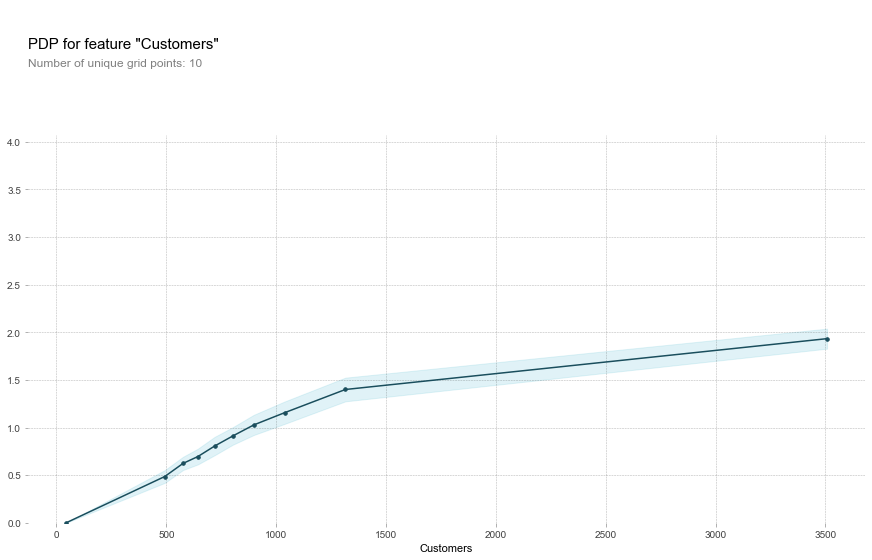

In [0]:
# Log Sales vs number of customers.

feature = 'Customers'

isolated = pdp_isolate(
    model=xgb_gs, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);